In [2]:
# Cell 1: Imports and Setup
import numpy as np
import torch
import matplotlib.pyplot as plt

from ardca import *
from utils import *

# Set parameters
msa_path = "../data/PF00014.fasta.gz"
q = 21
seed = 42
device = "cpu"

In [2]:
# Cell 2: Test MSA Loading and Preprocessing
print("Testing MSA loading...")
alignment = read_fasta_alignment(msa_path, max_gap_fraction=1.0)
print("Alignment shape:", alignment.shape)
print("First 5 sequences (indices):\n", alignment[:5])

Testing MSA loading...
Alignment shape: (13600, 53)
First 5 sequences (indices):
 [[ 0  2 10  3  4 10  7 13  6 15  2 16 12 20 18  4 15 19 20 20  3 15  6 17
   9  9  2 15 16  5 14 20  6  6  2  6  6 12 15 12  7  5 20 16  9  4 12  2
   8  5  7  2  0]
 [11  2 11  4 13 10 18 16  6 17  6  4  1  1 10 12 15  5  1 20 12  1 10 17
  15 14  2 10 13  5 18 20 16  6  8  6  6 12 14 12 12  5 10 16  9  1 16  2
   4  1 16  2  0]
 [ 1  2  9 10 10 14  3  8  6 13  2  9  1 16 18 17 15 19 16  5  3 11 16  9
   6  4  2 18 14  5 12 20  6  6  2  9  6 12  1 12 12  5  4 16  9  4  8  2
   4  3 15  2  0]
 [ 0  2 11 10 13 18 15  7  6 12  2 12  7  4  1 14 15 19  7  5  3  5  9 12
  20 15  2 17 13  5  9 20 15  6  2  4  6 12  1 12 12  5 10 16  4 12  1  2
  15 17  1  2 11]
 [18  2 16 14 13 10 18  8  6 12  6 12  6 12 18 17 15 19 20  1  3 13  4  3
  14 15  2  9 13  5 17 20 16  6 16  6  6 17 14 12 12  5 10 17  9  4  4  2
   4 16 16  2 15]]


In [3]:
# Cell 3: Test Sequence Weights
print("Testing sequence weights...")
weights, M_eff = compute_weights_blockwise(alignment, theta=0.8, gap_idx=0)
print("Weights shape:", weights.shape)
print("Effective sample size:", M_eff)
print("First 5 weights:", weights[:5])

Testing sequence weights...
Weights shape: (13600,)
Effective sample size: 4248.818911011662
First 5 weights: [0.03448276 0.25       1.         0.09090909 0.5       ]


In [4]:
# Cell 4: Test One-hot Encoding
print("Testing one-hot encoding...")
X_oh = encode_sequence(alignment, q=q, device=device)
print("One-hot shape:", X_oh.shape)
print("First sequence one-hot (sum over aa):", X_oh[0].sum(dim=-1))
print(X_oh.min().item(), X_oh.max().item())  # should be 0.0 and 1.0
print(X_oh.sum().item())                     # should equal M * L, 720800

# Recover indices from one-hot
decoded_idx = X_oh[0].argmax(dim=-1)  # shape (L,)
print(decoded_idx)

# Compare to your original alignment encoding (if you have it as ints)
print((decoded_idx == alignment[0]).all())

Testing one-hot encoding...
One-hot shape: torch.Size([13600, 53, 21])
First sequence one-hot (sum over aa): tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
0.0 1.0
720800.0
tensor([ 0,  2, 10,  3,  4, 10,  7, 13,  6, 15,  2, 16, 12, 20, 18,  4, 15, 19,
        20, 20,  3, 15,  6, 17,  9,  9,  2, 15, 16,  5, 14, 20,  6,  6,  2,  6,
         6, 12, 15, 12,  7,  5, 20, 16,  9,  4, 12,  2,  8,  5,  7,  2,  0])
tensor(True)


In [5]:
# Cell 5: Test Empirical Frequencies and Correlations
print("Testing empirical single-site and pairwise frequencies...")
f1 = compute_empirical_f1(alignment, weights, M_eff, q)
f2 = compute_empirical_f2(alignment, weights, M_eff, q)
print("Single-site freq shape:", f1.shape)
print("Pairwise freq shape:", f2.shape)


Testing empirical single-site and pairwise frequencies...
Single-site freq shape: (53, 21)
Pairwise freq shape: (53, 53, 21, 21)


In [6]:
print(f1.sum(axis=1))   # should be ~1.0 for every position
print(f2[0,1].sum())    # should be ~1.0
print(f2[3,3].sum())    # diagonal sites should also sum to ~1.0


[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1.]
0.9999999999999929
0.9999999999999922


In [7]:
# Cell 6: Model Initialization
print("Testing ArDCA model initialization...")
L = alignment.shape[1]
model = ArDCA(L=L, q=q, lambda_h=1e-6, lambda_J=1e-6)
model.init_parameters(torch.tensor(alignment, dtype=torch.long))
print("h_pos mean/std:", model.h_pos.mean().item(), model.h_pos.std().item())
print("J mean/std:", model.J.mean().item(), model.J.std().item())
print("J norm:", model.J.norm().item())

Testing ArDCA model initialization...
h_pos mean/std: 0.003602410899475217 0.09941249340772629
J mean/std: -3.446079426794313e-05 0.07002554088830948
J norm: 77.93736267089844


In [8]:
# Cell 7: Model Forward Pass
print("Testing model forward pass...")
logits = model.compute_ar_logits(X_oh)
print("Logits shape:", logits.shape)
print("Logits[0,0]:", logits[0,0])

Testing model forward pass...
Logits shape: torch.Size([13600, 53, 21])
Logits[0,0]: tensor([-0.0393,  0.0868, -0.0798, -0.2547, -0.0693, -0.0451,  0.0646,  0.0838,
         0.1139, -0.1354,  0.1305, -0.0974,  0.0206, -0.0318,  0.0539,  0.1182,
         0.1083, -0.1338,  0.1209,  0.0032, -0.0806],
       grad_fn=<SelectBackward0>)


In [9]:
# Cell 8: Model Loss Calculation
print("Testing model loss calculation...")
X_idx = torch.tensor(alignment, dtype=torch.long)
W = torch.tensor(weights, dtype=torch.float32)
loss, info = model.loss(X_oh, X_idx, W)
print("Loss:", loss.item())
print("Loss info:", info)

Testing model loss calculation...
Loss: 166.7855987548828
Loss info: {'nll': tensor(166.7795), 'regJ': tensor(6074.3945), 'regH': tensor(11.0042), 'total_loss': tensor(166.7856)}


In [13]:
# Cell 9: Model Training (Short Run)
print("Testing model training for 5 epochs...")
model_params = ModelParams(
    lambda_h=1e-6,
    lambda_J=1e-4,
    optimizer="lbfgs",
    max_iters=20,
    seed=seed,
    val_frac=0.1
)
msa_data = MSAData(
    seqs=alignment,
    weights=weights,
    M_eff=M_eff,
    L=L,
    q=q,
    identity_tresh=0.8
)
trained_model, history = train_ardca(model, msa_data, model_params, device=device)
print("Final J norm:", trained_model.J.norm().item())

Testing model training for 5 epochs...
Epoch 0: Train Loss=89.920174, Train NLL=89.310516
         Val Loss=91.595482, Val NLL=90.985825, Perplexity=1.7909
Epoch 10: Train Loss=59.101341, Train NLL=54.475594
         Val Loss=89.205994, Val NLL=84.580246, Perplexity=1.7189
Epoch 19: Train Loss=58.735142, Train NLL=53.952911
         Val Loss=88.951157, Val NLL=84.168922, Perplexity=1.7144
Final J norm: 218.60626220703125


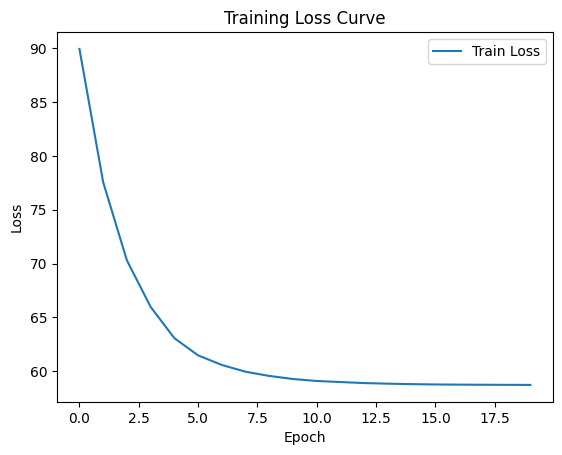

In [14]:
# Cell 10: Training History Plot
plt.plot(history['train_loss'], label='Train Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.legend()
plt.show()

In [15]:
# Cell 11: Sample Sequences from Model
print("Testing sequence sampling...")
samples = trained_model.sample_sequences(n_samples=5, device=device, seed=seed)
print("Sampled sequences:\n", samples.numpy())

Testing sequence sampling...
Sampled sequences:
 [[ 0  2  1 10 13 11 12 13  6 16  2  9 14  1  9 12 20 19  5 20  3 20 17 16
  15 17  2 16  8  5 19 20  6  6  2  4  6 12 14 12 15  5 16 17 14 10 11  2
  14 19 17  2  0]
 [ 8  2  9 16  8 18  3 16  6 13  2  5  6  1  8  9 15 19  1  5 12 15  8  4
  14  9  2  8 13  5  8 20  6  6  2  6  6 12  4 12 12  5 13 17 15  9  7  2
   4  3 17  2  1]
 [18  2  7 10 18 13  1 13  6 13  2 15  6 10  5 16 15 20 20 20 12 16 17  1
   6 14  2  4  8  5 10 20  6  6  2 10  6 12  1 12 12  5  3 17 13  4  4  2
   9 14 17  2  4]
 [10  2 16 10 13  1  3 13  6 14  2 12  6  6 11 20 14 20 20 20 12 13 17  8
   4 16  2  4  8  5 10 20  6  6  2  6  6 12 15 12 15  5 18 17 13 15  9  2
  10 14 17  2 14]
 [ 8  2  3 15 13  8  4  3  6 17  2 15  1  5  4 10 15 20  6  5 12 16  1 17
   6 15  2  4 14  5 19 20  6  6  2  6  6 12  4 12 16  5  6 16 10 10  3  2
  14 11 17  2  0]]
